In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import to_categorical





class CW2:
    """ C&W Attack (L2), changed from:
    https://github.com/tagomaru/ai_security/blob/
    Attributes:
        classifier (Model) : logits output
        k (float): hyperparameter change of k
        learning_rate (float): learning rate of the Adam Optimizer
        binary_search_steps (int): Binary Search Steps
        max_iterations (int): Max iteration numbers of the adversarial generation
        initial_c (float): initial constant value
    """

    def __init__(self, classifier, k = 0, learning_rate = 0.01,
                            binary_search_steps = 9, max_iterations = 1000,
                            initial_c = 0.01):

        # Import the corresponding classifier and define the self.variable
        self.classifier = classifier
        self.k = k
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.binary_search_steps = binary_search_steps
        self.initial_c = initial_c
            
    def is_satisfied_with_k(self, logits, target_class):
        """
        with k value increased, logits will basically increase
        「 k を加味したターゲットクラスの logit が最大」という制約を満たすか確認する。
        ターゲットクラスの logit から k　を引いた値が他のどのクラスの logit よりも大きければ　True を返し、
        そうでなければ、False を返す。
        Args:
            logits (ndarray): logits
            target_class (ndarray): target class
        Returns:
            satisfied (bool): whether k satisfy the objective.
        """
        logits = np.copy(logits)
        logits[target_class] -= self.k
        satisfied = np.argmax(logits) == target_class
        return satisfied    
    
    def generate(self, model, original_image, target_class_ohe):
        """
        Generate adversarial sample
        Args:
            original_image (ndarray): orginal shape -- (28, 28)
            target_class_ohe (ndarray): target class corresponding one-hot encoder (10, )
        Returns:
            o_best_adv_image (ndarray): adversarial class -- (28,28)
        """

        # set of the corresponding target class - argmax is used to find the best trusted class.
        target_class = np.argmax(target_class_ohe)

        # Define the orginal label
        original_label = model.predict(np.expand_dims(original_image, 0))
        original_label = np.argmax(original_label[0])
        
        # calcualte the shape of the original image
        shape = original_image.shape
               
        # constant and its corresponding limit
        c = self.initial_c
        c_lower = 0
        c_upper = 1e10

        #  (tanh(w) + 1) / 2 correspoinding w
        w = tf.Variable(np.zeros(shape, dtype=np.float32))
        
        # cast the corresponding tensor to the original image
        original_image = tf.cast(original_image, dtype=tf.float32)

        # generating adversarial samples
        def build_objective():

            # adversarial image generation
            adv_image = (tf.tanh(w) + 1) / 2

            # calculating objective
            objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

            # calculating adversarial samples.logits
            logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

            # calculating target classes logits
            target_logit = tf.reduce_sum(target_class_ohe * logits)
            
            # maximum logits other than target classes; logits
            other_max_logit = tf.reduce_max((1 - target_class_ohe) * logits + (target_class_ohe * np.min(logits)))
          
            # loss function 2
            objective2 = c * tf.maximum(0.0, other_max_logit - target_logit + self.k)

            # total loss function
            objective = objective1 + objective2

            return objective

        # loss function 
        objective = lambda: build_objective()
        
        
        o_best_objective1 = np.inf # initial value guess
        o_best_adv_image = np.zeros(shape) # initialize
        o_best_class = -1 # initialize
        loop_i = 0 # We also need to initialize the loop counter
        
        # for loop 
        for outer_step in range(self.binary_search_steps):
            
    
            best_objective1 = np.inf 
            best_class = -1 
            
            
            prev_objective = np.inf # initialize prev_objective
            
            # define adam optimizer
            opt = keras.optimizers.Adam(self.learning_rate)
            
            # Adam loop
            for iteration in range(self.max_iterations):
                

                opt.minimize(objective, var_list=[w])
                
                # calculate the logits of the adversarial samples
                adv_image = (tf.tanh(w) + 1) / 2
                logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

                objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

                # check every 10%
                if iteration % (self.max_iterations // 10) == 0:
                    if objective() > prev_objective * 0.9999:
                        break
                    prev_objective = objective()
                
                
                satisfied = self.is_satisfied_with_k(logits, target_class)

               
                if objective1 < best_objective1 and satisfied:
                    best_objective1 = objective1
                    best_class = target_class
                    
            
                if objective1 < o_best_objective1 and satisfied:
                    o_best_objective1 = objective1
                    o_best_class = target_class
                    o_best_adv_image = adv_image
                    loop_i = iteration # Here, we check the number of iteration to be able to output it

            
            if best_class == target_class:
                c_upper = c
                c = (c_lower + c_upper) / 2

            
            else:
                
                c_lower = c
                if c_upper < 1e9:                   
                    c = (c_lower + c_upper) / 2
                else:
                    c *= 10
            
            # print the output
            print('Binary Search {0}/{1}'.format(outer_step + 1, self.binary_search_steps))
            print('  L2 square: {0:.2f} - c: {1:.2f} - class: {2}'.format(o_best_objective1, c, o_best_class))
            print(f"original_label: {original_label}")
            print(f"adv_label: {np.argmax(self.classifier(tf.expand_dims(o_best_adv_image, axis=0)).numpy().flatten())}")


        # Calculate the total perturbation
        # r_tot = o_best_adv_image - original_image 
        # Generate adversarial label
        # adv_label = np.argmax(self.classifier(tf.expand_dims(o_best_adv_image, axis=0)).numpy().flatten()) 
        # ori_label is the original label
        # ori_label = original_label
        # # pert_image
        # pert_image = o_best_adv_image

        '''
        return value:
        r_tot (total perturbation); loop_i (number of iteration)
        ori_label (original label); adv_label (adversarial label); pert_image (adversarial image)
        '''

        return o_best_adv_image - original_image, loop_i, original_label, np.argmax(self.classifier(tf.expand_dims(o_best_adv_image, axis=0)).numpy().flatten()), o_best_adv_image

In [60]:
# model = keras.models.load_model('/ssd-sata1/mwt/def_project/DiffRobOT/DiffRobOT/MNIST/LeNet5_MNIST.h5')
# model_logits = keras.models.load_model('/ssd-sata1/mwt/def_project/DiffRobOT/DiffRobOT/MNIST/LeNet5_MNIST_logits.h5')
model = keras.models.load_model('/ssd-sata1/mwt/def_project/DiffRobOT/DiffRobOT/attacks/ai_security/models/mnist.h5')
model_logits = keras.models.load_model('/ssd-sata1/mwt/def_project/DiffRobOT/DiffRobOT/attacks/ai_security/models/mnist_logits.h5')

In [61]:
_, (X_test, Y_test) = keras.datasets.mnist.load_data()
X_test = X_test/255.0
original_image = X_test[0]
print(original_image.shape)

(28, 28)


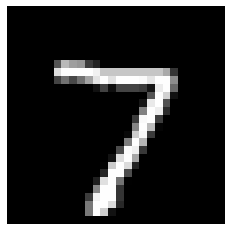

In [62]:
plt.axis('off')
plt.imshow(original_image, cmap=plt.cm.gray)
# Save the image to the local directory
#plt.savefig('original_image.png', bbox_inches='tight', pad_inches=0)

In [63]:
Y_hat = model.predict(np.expand_dims(original_image, 0)) # 推論結果
original_class = np.argmax(Y_hat, axis=1)[0] # 分類結果
original_score = np.max(Y_hat, axis=1)[0] # スコア

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_class, original_score * 100))

1/1 [==============================] - 0s 241ms/step
Prediction: 7 - score 99.91%


In [64]:
logits = model_logits.predict(np.expand_dims(original_image, 0)) # logits
original_class_logits = np.argmax(logits, axis=1)[0] # 分類結果
original_logit = np.max(logits, axis=1)[0] # オリジナルクラスの logit

# 分類結果と logit を表示
print('Prediction: {0} - logit {1:.2f}'.format(original_class_logits, original_logit))

1/1 [==============================] - 0s 178ms/step
Prediction: 7 - logit 12.28


In [69]:
print("start generating adversarial ")
print("start generating adversarial ")
print("start generating adversarial ")

target_class_ohe = to_categorical(0, num_classes=10) # ターゲットクラスを 0 とする

attack = CW2(model_logits, k=0) # k = 0 で CW2 のインスタンスを生成


adv_image_k0 = attack.generate(model, original_image, target_class_ohe) # 敵対的サンプルを生成
print("original_label")
print(adv_image_k0[2])
print("adv_label")
print(adv_image_k0[3])
print("maximum iter")
print(adv_image_k0[1])

start generating adversarial 
start generating adversarial 
start generating adversarial 
1/1 [==============================] - 0s 80ms/step
Binary Search 1/9
  L2 square: inf - c: 0.10 - class: -1
original_label: 7
adv_label: 5
Binary Search 2/9
  L2 square: inf - c: 1.00 - class: -1
original_label: 7
adv_label: 5
Binary Search 3/9
  L2 square: 1.77 - c: 0.55 - class: 0
original_label: 7
adv_label: 0
Binary Search 4/9
  L2 square: 1.76 - c: 0.33 - class: 0
original_label: 7
adv_label: 0
Binary Search 5/9
  L2 square: 1.76 - c: 0.44 - class: 0
original_label: 7
adv_label: 0
Binary Search 6/9
  L2 square: 1.76 - c: 0.38 - class: 0
original_label: 7
adv_label: 0
Binary Search 7/9
  L2 square: 1.76 - c: 0.41 - class: 0
original_label: 7
adv_label: 0
Binary Search 8/9
  L2 square: 1.76 - c: 0.40 - class: 0
original_label: 7
adv_label: 0
Binary Search 9/9
  L2 square: 1.76 - c: 0.39 - class: 0
original_label: 7
adv_label: 0
original_label
7
adv_label
0
maximum iter
219


In [ ]:
class CW2:
    """ C&W Attack (L2) による敵対的サンプルを生成
    Attributes:
        classifier (Model) : logits を出力するモデル
        k (float): 自信を調整するパラメータ
        learning_rate (float): Adam の学習率
        binary_search_steps (int): バイナリサーチの回数
        max_iterations (int): Adam の最大イテレーション回数
        initial_c (float): c の初期値
    """

    def __init__(self, classifier, k = 0, learning_rate = 0.01,
                            binary_search_steps = 9, max_iterations = 1000,
                            initial_c = 0.001):

        # 引数をすべてインスタンス変数にセット
        self.classifier = classifier
        self.k = k
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.binary_search_steps = binary_search_steps
        self.initial_c = initial_c
            
    def is_satisfied_with_k(self, logits, target_class):
        """
        「 k を加味したターゲットクラスの logit が最大」という制約を満たすか確認する。
        ターゲットクラスの logit から k　を引いた値が他のどのクラスの logit よりも大きければ　True を返し、
        そうでなければ、False を返す。
        Args:
            logits (ndarray): logits
            target_class (ndarray): ターゲットクラス
        Returns:
            satisfied (bool): 制約を満たす場合は True、そうでなければ False
        """
        logits = np.copy(logits)
        logits[target_class] -= self.k
        satisfied = np.argmax(logits) == target_class
        return satisfied    
    
    def generate(self, original_image, target_class_ohe):
        """
        敵対的サンプルを生成
        Args:
            original_image (ndarray): オリジナル画像 `(28, 28)`
            target_class_ohe (ndarray): ターゲットクラスの One-Hot `(10, )`
        Returns:
            o_best_adv_image (ndarray): 敵対的サンプル `(28, 28)`
        """

        # ターゲットクラスを変数にセット
        target_class = np.argmax(target_class_ohe)
        
        # オリジナル画像の型を変数にセット
        shape = original_image.shape
               
        # c とその下限値と上限値をセット
        c = self.initial_c
        c_lower = 0
        c_upper = 1e10

        #  (tanh(w) + 1) / 2 の w
        w = tf.Variable(np.zeros(shape, dtype=np.float32))
        
        #  オリジナル画像を Tensor にキャスト
        original_imgae = tf.cast(original_image, dtype=tf.float32)

        # 目的関数を生成する
        def build_objective():

            # 敵対的サンプルを格納する変数
            adv_image = (tf.tanh(w) + 1) / 2

            # 目的関数1
            objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

            # 敵対的サンプルの logits
            logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

            # ターゲットクラスの logit
            target_logit = tf.reduce_sum(target_class_ohe * logits)
            
            # ターゲットクラス以外の logit の最大値
            other_max_logit = tf.reduce_max((1 - target_class_ohe) * logits + (target_class_ohe * np.min(logits)))
          
            # 目的関数2
            objective2 = c * tf.maximum(0.0, other_max_logit - target_logit + self.k)

            # 目的関数
            objective = objective1 + objective2

            return objective

        # 目的関数を呼び出し可能な(callable)オブジェクトとしてセット
        objective = lambda: build_objective()
        
        # 目的関数の最小化の過程で見つかった最小の objective1、敵対的サンプル、分類結果を格納する変数
        o_best_objective1 = np.inf # 初期値として無限をセット
        o_best_adv_image = np.zeros(shape) # 初期値としてすべての要素に0をセット
        o_best_class = -1 # 初期値としてダミークラスをセット
        
        # バイナリサーチ用のループ
        for outer_step in range(self.binary_search_steps):
            
            # バイナリサーチのステップ内で見つかった最小の objective1 と分類結果を格納する変数
            best_objective1 = np.inf # 初期値として無限をセット
            best_class = -1 # 初期値としてダミークラスをセット
            
            # objective を保存しておく変数
            prev_objective = np.inf # 初期値として無限をセット
            
            # Adam のインスタンスを生成
            opt = keras.optimizers.Adam(self.learning_rate)
            
            # Adam を実行するループ
            for iteration in range(self.max_iterations):
                
                # Adam を実行
                opt.minimize(objective, var_list=[w])
                
                # 敵対的サンプルの logits 取得
                adv_image = (tf.tanh(w) + 1) / 2
                logits = self.classifier(tf.expand_dims(adv_image, axis=0))[0]

                objective1 = tf.reduce_sum(tf.square(adv_image - original_image))

                # max_iterations の 10% ごとに objective を確認
                if iteration % (self.max_iterations // 10) == 0:
                    # objective にほとんど変化がない、もしくは増えている場合は Adam のループを抜ける
                    if objective() > prev_objective * 0.9999:
                        break
                    # 次のステップの比較用に現在の objective を保存
                    prev_objective = objective()
                
                # 制約を満たすか確認
                satisfied = self.is_satisfied_with_k(logits, target_class)

                # objective1 が、best_objective1 より小さく、制約も満たせば、best_objective1 と best_class を更新する
                if objective1 < best_objective1 and satisfied:
                    best_objective1 = objective1
                    best_class = target_class
                    
                # objective1 が、o_best_objective1 より小さく、制約も満たせば、o_best_objective1, o_best_class, o_best_adv_image を更新する
                if objective1 < o_best_objective1 and satisfied:
                    o_best_objective1 = objective1
                    o_best_class = target_class
                    o_best_adv_image = adv_image

            # 現在のバイナリサーチのステップで制約を満たしている場合
            if best_class == target_class:
                # c の上限値に現在の c をセットする
                c_upper = c

                # c に　「現在の c」　と　「c の下限値」　の平均値をセットする
                c = (c_lower + c_upper) / 2

            # 見つからなかった場合
            else:
                # c の下限値に現在の c をセットする
                c_lower = c
                if c_upper < 1e9:
                    # c の上限値が 1e9 未満の場合は、c に　「現在の c」　と　「c の上限値」　の平均値をセットする
                    c = (c_lower + c_upper) / 2
                else:
                    # それ以外は、c が大きくなりすぎないように、c を 10 倍する
                    c *= 10
            
            # ログ出力
            print('Binary Search {0}/{1}'.format(outer_step + 1, self.binary_search_steps))
            print('  L2 square: {0:.2f} - c: {1:.2f} - class: {2}'.format(o_best_objective1, c, o_best_class))

        # 敵対的サンプルを ndarray に変換して返す
        return o_best_adv_image.numpy()

In [68]:
target_class_ohe = to_categorical(0, num_classes=10) # ターゲットクラスを 0 とする

attack = CW2(model_logits, k=0) # k = 0 で CW2 のインスタンスを生成
adv_image_k0 = attack.generate(original_image, target_class_ohe) # 敵対的サンプルを生成

TypeError: generate() missing 1 required positional argument: 'target_class_ohe'

In [ ]:
# 推論結果。 model_logits ではなく、model での推論である点に注意
Y_hat_k0 = model.predict(np.expand_dims(adv_image_k0, 0))

# スコア
score_k0 = np.max(Y_hat_k0[0])

# 分類結果
class_k0 = np.argmax(Y_hat_k0[0])

# L2
L2_k0 = np.linalg.norm(adv_image_k0 - original_image)

# 敵対的サンプルを表示
plt.axis('off')
plt.title('{0} - {1:.2f}% - {2:.2f}'.format(class_k0, score_k0 * 100, L2_k0))
plt.imshow(adv_image_k0, cmap=plt.cm.gray)

1/1 [==============================] - 0s 42ms/step
[[2.47730628e-01 2.47928183e-05 9.15350765e-02 1.12918034e-01
  3.40114129e-05 2.22814400e-02 1.27208068e-06 2.47563064e-01
  2.46795654e-01 3.11160404e-02]]
0


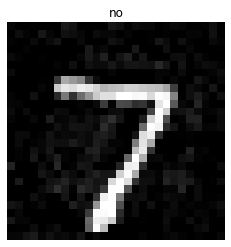

In [70]:
# 推論結果。 model_logits ではなく、model での推論である点に注意
Y_hat_k0  = model.predict(np.expand_dims(adv_image_k0[4], 0))
print(Y_hat_k0)

class_k0  = np.argmax(Y_hat_k0, axis = 1)[0]
print(class_k0)

plt.axis('off')
plt.title("no")
plt.imshow(adv_image_k0[4], cmap=plt.cm.gray)